# Machine Learning 2 Project

In [1]:
# !pip install kagglehub
# !pip install tensorflow
# !pip install tensorflow-gpu


In [2]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import re
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
#import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

stock_name = 'TSLA'
# Download the dataset
filtered_df = pd.read_csv('final_dataset_indexes.csv')

# Print the total number of tweets
total_rows = len(filtered_df)
print(f"Total number of rows in the dataset: {total_rows}")

#filtered_df = dataset[dataset['Stock Name'] == stock_name]
filtered_df

2025-01-04 17:35:57.375341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 17:35:57.774172: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 17:35:59.718537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-04 17:35:59.718678

Total number of rows in the dataset: 2016


,Date,Open,High,Low,Close,Volume,Stock Name,Z_Score_Normalized,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,TSLA,0.003853,NaN,NaN,-1.839996,NaN,NaN,NaN,258.493347,5.550994
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,TSLA,0.708987,NaN,NaN,-1.751664,NaN,NaN,NaN,258.428345,5.550657
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,TSLA,0.473943,NaN,NaN,-1.826312,NaN,NaN,NaN,259.869497,5.558795
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,TSLA,-0.936325,NaN,NaN,-1.634578,NaN,NaN,NaN,260.090329,5.557587
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,TSLA,-0.701281,NaN,NaN,-0.934345,NaN,NaN,NaN,260.643490,5.560361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2022-09-23,18.000000,18.209999,17.420000,17.639999,39484400,NIO,-0.466236,19.608571,19.5170,0.061878,1.589290,22.695580,16.338420,17.954225,2.811809
2012,2022-09-26,17.770000,18.400000,17.530001,17.620001,42024500,NIO,-0.701281,19.052857,19.4020,0.188659,1.640968,22.683935,16.120065,17.731409,2.810607
2013,2022-09-27,18.180000,18.230000,16.980000,17.190001,40675200,NIO,-0.113669,18.630000,19.2710,0.189200,1.709816,22.690633,15.851367,17.370470,2.784394
2014,2022-09-28,16.799999,17.459999,16.660000,17.330000,37295600,NIO,-0.231191,18.120000,19.1460,0.398865,1.757517,22.661035,15.630965,17.343490,2.793004


In [3]:
# We drop the useless columns: date because the past for each day is embedded in the technical financial datapoints
filtered_df.dropna(inplace=True)
filtered_df.dropna(subset=['MA20'], inplace=True)
target_feature = filtered_df[['Close']]
filtered_df.drop(columns=['Date','Close'], inplace=True)
filtered_df

,Open,High,Low,Volume,Stock Name,Z_Score_Normalized,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
19,346.553345,356.959991,343.593323,115579500,TSLA,4.117135,314.995235,283.829501,-6.873491,28.711192,341.251886,226.407117,342.505743,5.843409
20,356.103333,360.333344,351.399994,81639600,TSLA,1.179077,325.127141,288.855501,-9.269895,32.580099,354.015698,223.695304,353.510805,5.880570
21,360.619995,371.736664,357.736664,89755200,TSLA,2.119255,336.946189,294.501834,-10.609662,36.566908,367.635649,221.368019,365.392497,5.914404
22,381.666656,403.250000,372.886658,168146100,TSLA,1.296599,351.926666,301.619501,-11.860446,42.906989,387.433479,215.805523,390.373061,5.996112
23,386.453339,402.863342,382.000000,128213400,TSLA,2.001733,364.418095,308.143001,-14.295169,46.078655,400.300312,215.985690,390.568791,5.965292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,18.000000,18.209999,17.420000,39484400,NIO,-0.466236,19.608571,19.517000,0.061878,1.589290,22.695580,16.338420,17.954225,2.811809
2012,17.770000,18.400000,17.530001,42024500,NIO,-0.701281,19.052857,19.402000,0.188659,1.640968,22.683935,16.120065,17.731409,2.810607
2013,18.180000,18.230000,16.980000,40675200,NIO,-0.113669,18.630000,19.271000,0.189200,1.709816,22.690633,15.851367,17.370470,2.784394
2014,16.799999,17.459999,16.660000,37295600,NIO,-0.231191,18.120000,19.146000,0.398865,1.757517,22.661035,15.630965,17.343490,2.793004


In [4]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    scaler = MinMaxScaler(feature_range=(-1, 1))

    c1 = scaler.fit_transform(dataset[['Sentiment_Numeric']])
    c2 = scaler.fit_transform(dataset[['Close']])
#     c1 = (c1 - c1.min()) / (c1.max() - c1.min())
#     c2 = (c2 - c2.min()) / (c2.max() - c2.min())

    ax.plot(dataset['Date'], c1, label='Sentiment_Numeric', color='g', linestyle='--')

#     ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], c2, label='Close', color='#6A5ACD')
#     ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
#     plt.title('Technical indicators')
    plt.ylabel('Normalized Value')
    plt.xlabel("Year")
    plt.legend()

    plt.savefig('closing_vs_sentscore.png')

    plt.show()

#tech_ind(filtered_df)

In [5]:
target_feature

,Close
19,345.953339
20,359.013336
21,371.333344
22,402.863342
23,390.666656
...,...
2011,17.639999
2012,17.620001
2013,17.190001
2014,17.330000


In [6]:
print(filtered_df.shape)
print(target_feature.shape)

(1861, 14)
(1861, 1)


The entire DataFrame is copied to data to ensure that all columns are normalized. The target column (the one we want to predict is considered apart).

Two instances of MinMaxScaler are created:
- X_scaler for normalizing all features.
- y_scaler for normalizing only the target column.

In [7]:
def normalize_data(df, range):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)

    X_scale_dataset = X_scaler.fit_transform(data)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))

    return X_scale_dataset

def normalize_target(df, range):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    data = pd.DataFrame(df.iloc[:, :])

    y_scaler = MinMaxScaler(feature_range=range)
    y_scaler.fit(data)

    y_scale_dataset = y_scaler.fit_transform(data)

    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return y_scale_dataset

In [8]:
dataset = filtered_df
new_dataset = pd.get_dummies(dataset, columns=['Stock Name'], prefix='Stock')
X_scale_dataset = normalize_data(new_dataset, (0,1)) # TRIED (-1,1) and (0,1), nothing changes
y_scale_dataset = normalize_target(target_feature, (0,1))

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC  # SVM is generally referenced with SVC in sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_scale_dataset, y_scale_dataset, test_size=0.1, random_state=42, shuffle=True)
# split the dataset into train and test keeping last 10% as test set (should be last 180 days of NIO stock)
# Sequential Splitting Creates Distribution Issues:

# With shuffle=False, the split is sequential:
# Training set: The first 90% of the data.
# Test set: The last 10% of the data.
# In time series or ordered datasets, this means the training and testing sets may come from different distributions.

input_dim = X_train.shape[1]
feature_size = X_train.shape[1]
output_dim = y_train.shape[1]

def plot_test_data_custom(Real_test_price, Predicted_test_price):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))

    Predicted_test_price = Predicted_test_price.reshape(-1, 1)

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)
    
    predicted = rescaled_Predicted_price
    real = rescaled_Real_price

    RMSE = np.sqrt(mean_squared_error(predicted, real))
    mse = mean_squared_error(predicted, real)
    mae = mean_absolute_error(predicted, real)
    print('Test RMSE: ', RMSE)
    print('Test MSE:', mse)
    print('Test MAE:', mae)

    plt.figure(figsize=(10, 5))
    plt.plot(real, color='#00008B')
    plt.plot(predicted, color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=8)
    plt.title(f"Prediction on test data", fontsize=14)
    plt.show()

## Random Forest algorithm

The rf_param_grid dictionary specifies a range of hyperparameter values to test:
- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree (None means no limit).
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.

GridSearchCV is initialized with:
- Model: RandomForestRegressor(random_state=42) (ensures reproducibility).
- Parameter Grid: rf_param_grid.
- Cross-Validation (cv=5): Splits the data into 5 folds for cross-validation.
- Scoring Metric: neg_mean_squared_error (negative MSE; smaller is better).

The fit method trains multiple Random Forest models using all combinations of hyperparameter values in rf_param_grid.
Cross-validation evaluates each combination. The best combination of hyperparameters (minimizing the negative MSE) is automatically chosen and we use it to make the predictions.

At the leaf nodes (where splitting stops), the prediction is typically the mean of the target values in that leaf

Random Forest - Best Params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test RMSE:  2.2065957702934935
Test MSE: 4.869064893477136
Test MAE: 1.1383407954659759


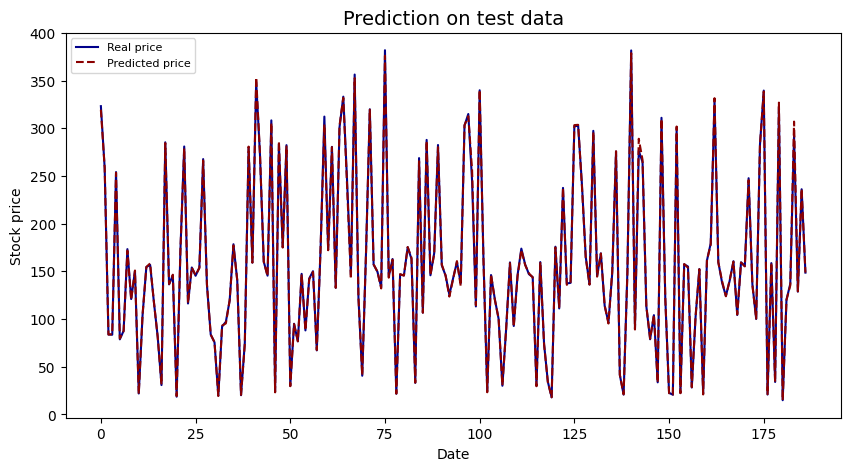

In [9]:
# Define Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 300],         # Reduced number of trees to two options (fewer than original range)
    'max_depth': [10, 20, None],       # Fewer depth options, focusing on practical limits and no limit
    'min_samples_split': [2, 5],       # Reduced options for splits
    'min_samples_leaf': [1, 2],        # Fewer options for leaf size
    'max_features': ['sqrt', 'log2'],  # Dropped `None` as it is less commonly used
    'bootstrap': [True]                # Bootstrap is usually True in Random Forest; removed False
}
# Initialize and fit GridSearchCV for Random Forest
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Retrieve best model and predictions
best_rf_model = rf_grid.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
print(f'Random Forest - Best Params: {rf_grid.best_params_}')

plot_test_data_custom(y_test, rf_predictions)

In [10]:
import numpy as np

# Check for NaNs in NumPy arrays
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())

# Locate rows with NaNs
nan_rows_indexes = np.where(np.isnan(X_train))[0]
print("NaN locations in X_train:", nan_rows_indexes)

# Example: Assuming your array is named `data_array`
X_train_clean = X_train[~np.isnan(X_train).any(axis=1)]

print("Original shape X:", X_train.shape)
print("Cleaned shape X:", X_train_clean.shape)
y_train_clean = np.delete(y_train, nan_rows_indexes, axis=0)

print("Original shape y:", y_train.shape)
print("Cleaned shape y:", y_train_clean.shape)

NaNs in X_train: 0
NaNs in X_test: 0
NaN locations in X_train: []
Original shape X: (1674, 21)
Cleaned shape X: (1674, 21)
Original shape y: (1674, 1)
Cleaned shape y: (1674, 1)


## Linear regression algorithm

Ridge regression is simply Linear regression with one key hyperparameter, alpha:
- Controls the amount of regularization applied to the model.
- Smaller values (e.g., 0.1) reduce regularization, making the model closer to standard linear regression.
- Larger values (e.g., 100) increase regularization, penalizing large coefficients to prevent overfitting.

Training Data Errors:
RMSE: 0.0026, MSE: 0.0000, MAE: 0.0016
Test RMSE:  1.1618364357259132
Test MSE: 1.349863903380294
Test MAE: 0.6585331633422464


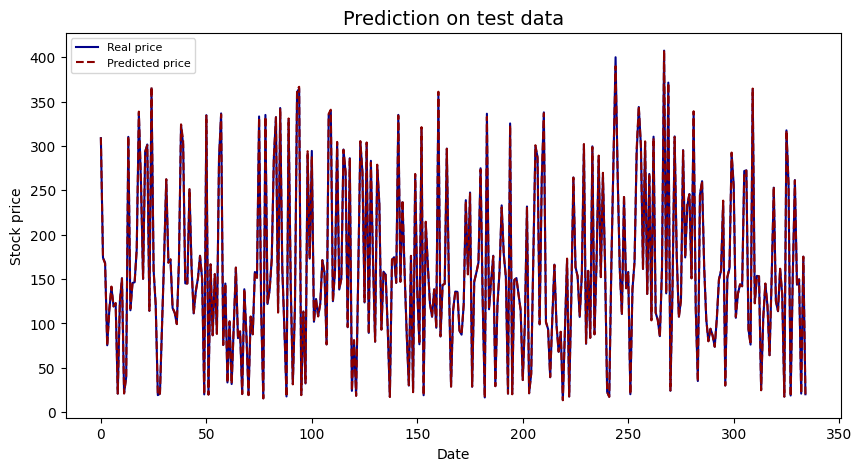

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Linear Regression Model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_clean, y_train_clean)

# Predictions on training data
y_train_predictions = lr_model.predict(X_train_clean)

# Predictions on test data
y_test_predictions = lr_model.predict(X_test)

# Calculate errors for training data
train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_train_predictions))
train_mse = mean_squared_error(y_train_clean, y_train_predictions)
train_mae = mean_absolute_error(y_train_clean, y_train_predictions)

# Print error metrics
print("Training Data Errors:")
print(f"RMSE: {train_rmse:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")

# Custom function to plot test data
plot_test_data_custom(y_test, y_test_predictions)


### Overfitting
The significant disparity between the extremely low training errors (RMSE: 0.0026) and much higher test errors (RMSE: 1.16) indicates overfitting, as the model performs well on training data but fails to generalize to unseen data; we will address this issue using regularization techniques to improve model generalization.

### Ridge Regression Model

Alpha: 0.0001
Training RMSE: 0.0026, MSE: 0.0000, MAE: 0.0000
Test RMSE: 0.0027, MSE: 0.0000, MAE: 0.0000
--------------------------------------------------
Alpha: 0.001
Training RMSE: 0.0026, MSE: 0.0000, MAE: 0.0000
Test RMSE: 0.0027, MSE: 0.0000, MAE: 0.0000
--------------------------------------------------
Alpha: 0.01
Training RMSE: 0.0028, MSE: 0.0000, MAE: 0.0000
Test RMSE: 0.0029, MSE: 0.0000, MAE: 0.0000
--------------------------------------------------
Alpha: 0.1
Training RMSE: 0.0049, MSE: 0.0000, MAE: 0.0000
Test RMSE: 0.0050, MSE: 0.0000, MAE: 0.0000
--------------------------------------------------
Alpha: 1
Training RMSE: 0.0081, MSE: 0.0001, MAE: 0.0001
Test RMSE: 0.0082, MSE: 0.0001, MAE: 0.0001
--------------------------------------------------
Alpha: 10
Training RMSE: 0.0139, MSE: 0.0002, MAE: 0.0002
Test RMSE: 0.0140, MSE: 0.0002, MAE: 0.0002
--------------------------------------------------
Alpha: 100
Training RMSE: 0.0281, MSE: 0.0008, MAE: 0.0008
Test RMSE: 0.0

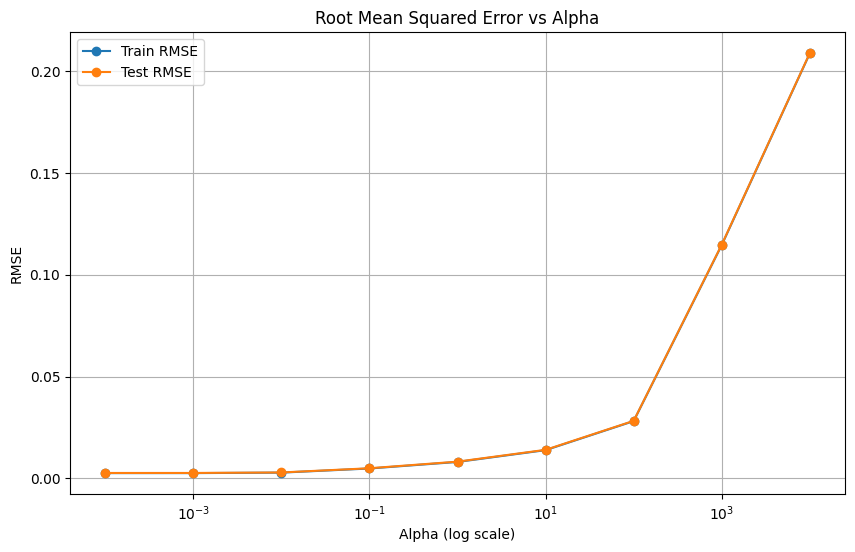

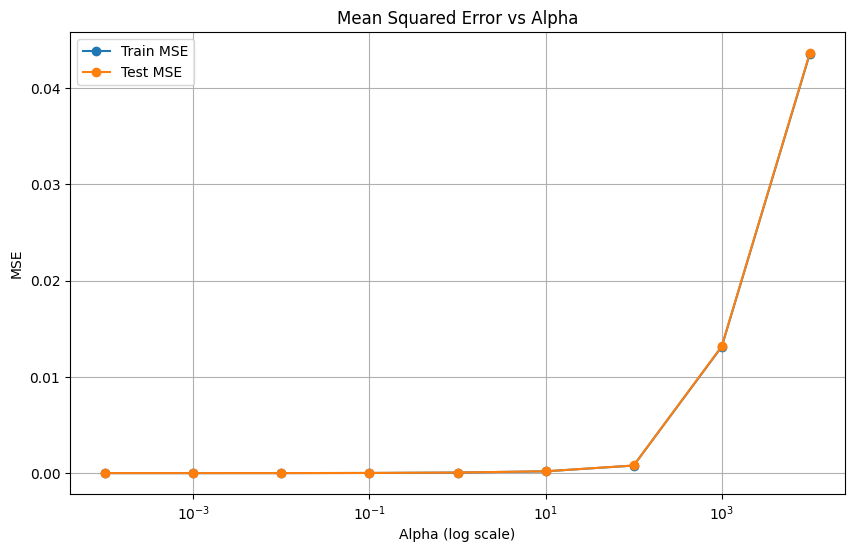

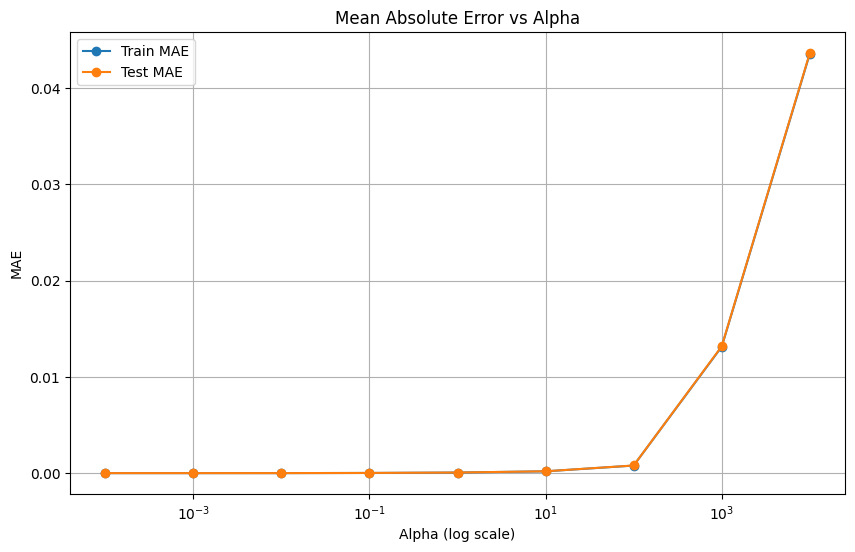

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut

# Define alpha values
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Initialize lists to store errors
train_rmse = []
train_mse = []
train_mae = []
test_rmse = []
test_mse = []
test_mae = []

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
n_splits = loo.get_n_splits(X_train_clean)

# Train and evaluate Ridge Regression model for different alphas
for alpha in alpha_values:
    model = Ridge(alpha=alpha)

    # Initialize metrics for LOOCV
    loo_train_errors = []
    loo_test_errors = []

    for train_idx, test_idx in loo.split(X_train_clean):
        X_train, X_test = X_train_clean[train_idx], X_train_clean[test_idx]
        y_train, y_test = y_train_clean[train_idx], y_train_clean[test_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predict and calculate errors for LOOCV
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Collect errors for this LOOCV split
        loo_train_errors.append(mean_squared_error(y_train, y_train_pred))
        loo_test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Average the errors across all LOOCV splits
    avg_train_mse = np.mean(loo_train_errors)
    avg_test_mse = np.mean(loo_test_errors)

    # Compute RMSE and MAE for reporting
    train_rmse.append(np.sqrt(avg_train_mse))
    train_mse.append(avg_train_mse)
    train_mae.append(np.mean(np.abs(np.array(loo_train_errors))))

    test_rmse.append(np.sqrt(avg_test_mse))
    test_mse.append(avg_test_mse)
    test_mae.append(np.mean(np.abs(np.array(loo_test_errors))))

# Print results
for i, alpha in enumerate(alpha_values):
    print(f"Alpha: {alpha}")
    print(f"Training RMSE: {train_rmse[i]:.4f}, MSE: {train_mse[i]:.4f}, MAE: {train_mae[i]:.4f}")
    print(f"Test RMSE: {test_rmse[i]:.4f}, MSE: {test_mse[i]:.4f}, MAE: {test_mae[i]:.4f}")
    print("-" * 50)

# Plot errors
plt.figure(figsize=(10, 6))

# RMSE plot
plt.plot(alpha_values, train_rmse, label='Train RMSE', marker='o')
plt.plot(alpha_values, test_rmse, label='Test RMSE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

# MSE plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_mse, label='Train MSE', marker='o')
plt.plot(alpha_values, test_mse, label='Test MSE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('MSE')
plt.title('Mean Squared Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

# MAE plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_mae, label='Train MAE', marker='o')
plt.plot(alpha_values, test_mae, label='Test MAE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('MAE')
plt.title('Mean Absolute Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()


## Best Alpha

**α=0.001** strikes the best balance:

- **Training RMSE**: **0.0026**  
- **Test RMSE**: **0.0027**

The error gap is minimal, and both values are extremely low, indicating excellent generalization without signs of overfitting or underfitting. The model performs almost equally well on both the training and test data.

A slightly larger alpha (**α=0.01**) marginally increases both training and test errors:  
- **Training RMSE**: **0.0028**  
- **Test RMSE**: **0.0029**  
This suggests that stronger regularization slightly hinders the model's ability to capture underlying patterns.

For much larger alphas (**α=10** and above), the training and test errors increase significantly:  
- **For α=10**: **Training RMSE: 0.0139**, **Test RMSE: 0.0140**  
This indicates underfitting, as excessive regularization reduces the model's ability to learn relationships in the data.

### Conclusion

The optimal value is **α=0.001**, as it achieves the lowest errors while maintaining a good balance between training and test performance.

## K-Nearest Neighbors regression algorithm

Creates a KNN regression model with the hyperparameter n_neighbors=5:
- Specifies that the model will use the 5 nearest neighbors to make predictions.
- The predicted value for a data point is typically the average of the target values of its 5 nearest neighbors.

A higher value of n_neighbors leads to smoother predictions (more averaging), which may reduce variance but increase bias.
A lower value captures finer details in the data but risks overfitting.

Test RMSE:  4.726411126135208
Test MSE: 22.338962133254686
Test MAE: 2.941187992197947


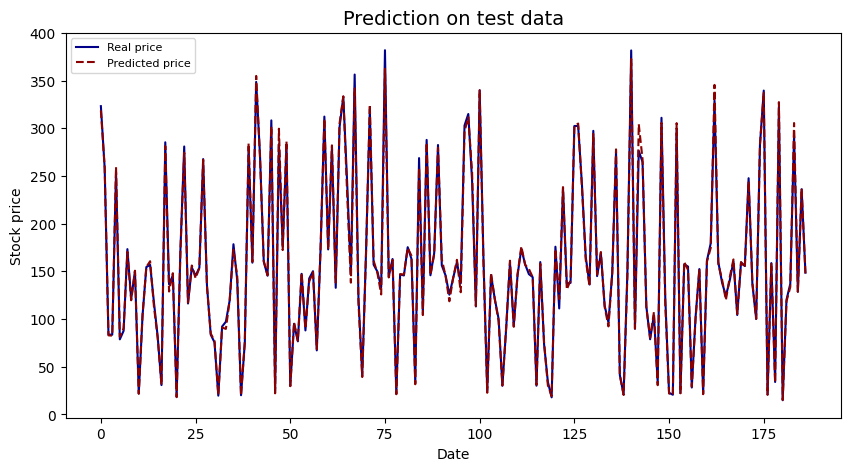

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# KNN algorithm
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn.fit(X_train_clean, y_train_clean)

# Step 4: Make Predictions
knn_predictions = knn.predict(X_test)

plot_test_data_custom(y_test, knn_predictions)

In [14]:
print(X_train)

[[0.29471918 0.29776916 0.29985025 ... 0.         0.         0.        ]
 [0.66157047 0.66154008 0.66937115 ... 0.         0.         0.        ]
 [0.86849294 0.87066638 0.83375493 ... 0.         1.         0.        ]
 ...
 [0.2263716  0.23264074 0.23056034 ... 0.         0.         0.        ]
 [0.26624727 0.26413195 0.26020526 ... 0.         0.         1.        ]
 [0.21421589 0.21035734 0.20812359 ... 0.         0.         0.        ]]
